In [1]:
%matplotlib inline

import os
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage
import skimage
import scipy.stats
import scipy
from pprint import pprint
from sklearn.linear_model import LinearRegression

plt.rcParams['figure.figsize'] = [15, 11]

In [2]:
global_scaling = 4

def load_images(path, name):
    """
        Loads original, thermal and visible image from dataset
    """
    original = cv2.imread(os.path.join(path, name)) / 255
    thermal = cv2.imread(os.path.join(path, "extracted/thermal", name)) / 255
    visible = cv2.imread(os.path.join(path, "extracted/visible", name)) / 255
    return original, thermal, visible

def load_prepare(path, name):
    """
        Loads images, scales VIS and FIR to shape and collapses to 1 channel
    """
    orig, thr, vis = load_images(path, name)
    
    # Compress into single channel
    thr = np.mean(thr, 2)
#     vis = np.mean(vis, 2)
#     print(vis.shape)
    
    vis = skimage.color.rgb2lab(vis)[..., 0]

    # Align shapes
#     vis = cv2.resize(vis, (120, 160))
#     thr = cv2.resize(thr, (120, 160))
    vis = cv2.resize(vis, (thr.shape[1]//global_scaling, thr.shape[0]//global_scaling))
    thr = cv2.resize(thr, (thr.shape[1]//global_scaling, thr.shape[0]//global_scaling))
    return orig, thr, vis

def superimpose(a, b):
    """
        Superimposes 2 images
    """
    return np.mean(np.dstack([a, b]), axis=2)

def show(img, ax, title, neg=True):
    """
        Displays an image.
        Uses negative by default for better visibility.
    """
    ax.imshow(1-img if neg else img)
    ax.set_title(title)
    ax.axis("off")

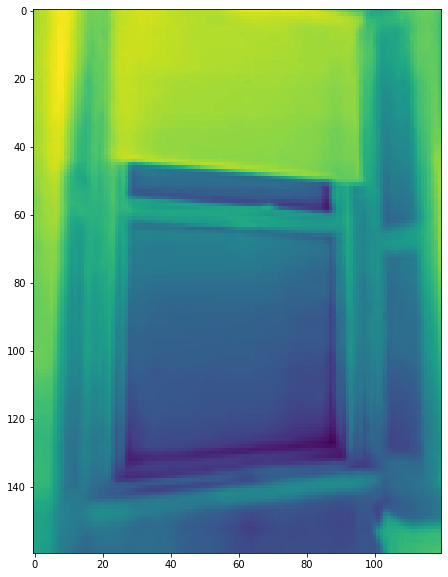

In [12]:
root_path = "../../data/calibration_rotation"
with open(os.path.join(root_path, "metadata.json")) as f:
    metadata = json.load(f)

orig, fir, rgb = load_prepare(root_path, list(metadata["photos"].keys())[0])

plt.figure(figsize=(10, 10))
plt.imshow(fir)

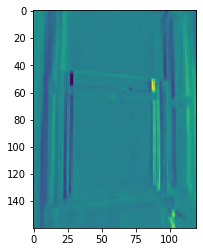

In [13]:
kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])

x_gradient = ndimage.convolve(fir, kx)
plt.imshow(x_gradient)

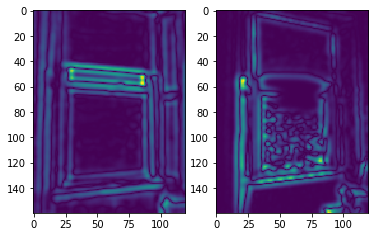

In [24]:
sigma = 2

# fir_gaussian = scipy.ndimage.filters.gaussian_filter(fir, sigma=sigma)
# rgb_gaussian = scipy.ndimage.filters.gaussian_filter(rgb, sigma=sigma)


fir_laplacian = scipy.ndimage.gaussian_laplace(fir, sigma)
rgb_laplacian = scipy.ndimage.gaussian_laplace(rgb, sigma)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(abs(fir_laplacian))
ax2.imshow(abs(rgb_laplacian))

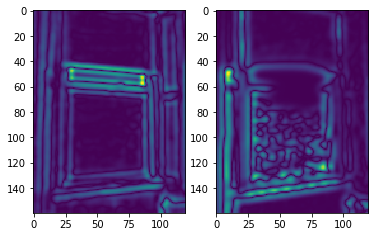

In [25]:
trans = np.array([
    [ 1.22625812e+00, -1.21753247e-03, -1.60819805e+01],
    [-2.71915584e-02,  1.20373377e+00, -1.66152597e+01],
])

rgb_trans = cv2.warpAffine(rgb_laplacian, trans, (fir.shape[1], fir.shape[0]))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(abs(fir_laplacian))
ax2.imshow(abs(rgb_trans))

In [27]:
print(ntg(fir_laplacian, rgb_laplacian))
print(ntg(fir_laplacian, rgb_trans))

0.9970186624195416
0.9972504583879808


## NTG

1. Normalize images to [0, 1]
1. Subtract images for difference
1. (plot gradient distributions)

$NTG(f, f_R) = \frac{\sum_l |\nabla_l \{f - f_R\}|}{\sum_l | \nabla_l f | + \sum_l | \nabla_l f_R|}$ with $l \in \{x, y\}$

In [10]:
def plot_gradients(imgs, names, bins=50):
    
    distributions = []
    x_scales = []
    
    # x and y gradient kernel
    kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])

    # Get gradients
    for img in imgs:
        x_gradient = ndimage.convolve(img, kx)
        y_gradient = ndimage.convolve(img, ky)
        total_samples = img.shape[0] * img.shape[1] * 2

        combined_gradient, x_scale = np.histogram(np.array([x_gradient, y_gradient]).flatten(), bins=bins)
        combined_gradient = combined_gradient / total_samples
        distributions.append(combined_gradient)
        x_scales.append(x_scale[:-1])
    
    fig, ax = plt.subplots(1)
    ax.set_yscale('log')
    ax.set_xlabel("Gradient of channel difference")
    ax.set_ylabel("Probability")
    for distribution, x_scale, name in zip(distributions, x_scales, names):
        ax.plot(x_scale, distribution, label=name)
    ax.legend()
    
def total_gradient(f, norm=1):
    kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])
    
    dx = ndimage.convolve(f, kx)
    dy = ndimage.convolve(f, ky)
    
    return np.linalg.norm(dx, norm) + np.linalg.norm(dy, norm)

def ntg(f, f_ref):
    return total_gradient(f - f_ref) / (total_gradient(f) + total_gradient(f_ref))

[[ 1.20691758  0.03655698]
 [-0.01696484  1.16659089]] [-79.20458802 -23.70966053]
0.9961457038453945
0.9976953410464918


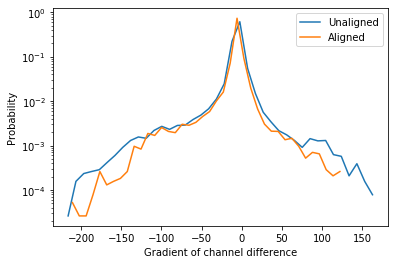

In [11]:
root_path = "../../data/calibration"
with open(os.path.join(root_path, "metadata.json")) as f:
    metadata = json.load(f)
    
scaling_factor = metadata["shape"]["vis"][0] / metadata["shape"]["thr"][0]

X, y = [], []
for name, image in metadata["photos"].items():
    try:
        X.append(metadata["photos"][name]["points"]["vis"])
        y.append(metadata["photos"][name]["points"]["thr"])
    except:
        pass
    
X = np.vstack(X) // scaling_factor
y = np.vstack(y)

model = LinearRegression()
model.fit(X, y)

print(model.coef_, model.intercept_)

orig, fir, rgb = load_prepare(root_path, list(metadata["photos"].keys())[1])

transformation = np.hstack([model.coef_, model.intercept_[:, None]])
rgb_trans = cv2.warpAffine(rgb, transformation, (fir.shape[1], fir.shape[0]))

print(ntg(rgb, fir))
print(ntg(rgb_trans, fir))

plot_gradients([rgb-fir, rgb_trans-fir], ["Unaligned", "Aligned"], bins=40)

[[ 1.22625812e+00 -1.21753247e-03 -1.60819805e+01]
 [-2.71915584e-02  1.20373377e+00 -1.66152597e+01]]
0.9973503603327698
0.9986142968141252


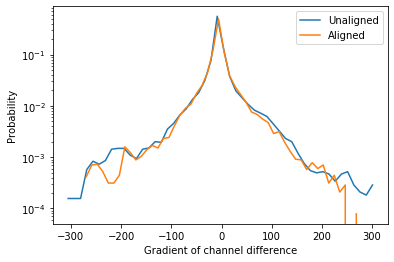

In [9]:
root_path = "../../data/calibration_rotation"
with open(os.path.join(root_path, "metadata.json")) as f:
    metadata2 = json.load(f)
    
# scaling_factor = metadata["shape"]["vis"][0] / metadata["shape"]["thr"][0]

X = metadata2["photos"]["flir_20191116T103250.jpg"]["points"]["vis"]
y = metadata2["photos"]["flir_20191116T103250.jpg"]["points"]["thr"]
    
X = np.vstack(X) // scaling_factor // global_scaling
y = np.vstack(y) // global_scaling

model = LinearRegression()
model.fit(X, y)

transformation = np.hstack([model.coef_, model.intercept_[:, None]])
print(transformation)

orig2, fir2, rgb2 = load_prepare(root_path, "flir_20191116T103250.jpg")
print(ntg(rgb2, fir2))

rgb2_trans = cv2.warpAffine(rgb2, transformation, (fir2.shape[1], fir2.shape[0]))
print(ntg(rgb2_trans, fir2))

plot_gradients([fir2-rgb2, fir2-rgb2_trans], ["Unaligned", "Aligned"], bins=50)

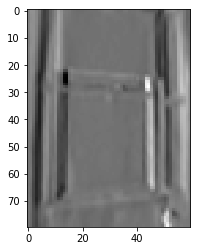

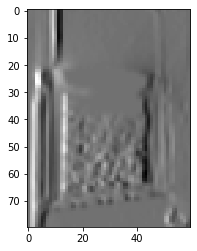

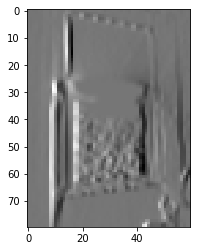

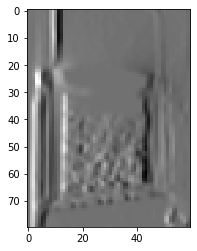

In [35]:
def gradient(f, norm=1):
    kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])
    
    dx = ndimage.convolve(f, kx)
    dy = ndimage.convolve(f, ky)
    
    plt.figure()
    plt.imshow(dx, cmap="gray")
    
gradient(fir2)
gradient(rgb2_trans)
gradient(rgb2 - fir2)
gradient(fir2+rgb2_trans)

## Optimization

In [ ]:
from scipy.optimize import differential_evolution

In [ ]:
def ntg_loss(trans, rgb_, fir_):
    trans = trans.reshape(2, 3)
    rgb_transformed_ = cv2.warpAffine(rgb_, trans, (fir_.shape[1], fir_.shape[0]))
    loss = ntg(rgb_transformed_, fir_)
#     print(loss)
    return loss

In [ ]:
%%time
bounds = [(1, 1.25), (-0.02, 0.02), (-50, -80), (-0.02, 0.02), (1, 1.25), (-50, -80)]
result = differential_evolution(func=ntg_loss, bounds=bounds, args=(fir2, rgb2), popsize=30, maxiter=200)

In [ ]:
trained_transformation = np.array(result.x).reshape(2, 3)
print(trained_transformation)
print(result)
print(ntg_loss(trained_transformation, rgb2, fir2))
print(ntg_loss(transformation, rgb2, fir2))

In [ ]:
def show_transform(thr, vis, metadata, transformation, scaling_factor):
    """
        Displays transformation vectors as an overlay
        over the superimposed FIR and RGB image
    """
    
    print(transformation)
    
    coef = transformation[:, :2]
    intercept = transformation[:, 2]
    
    # Display superimposed image
    sup = superimpose(vis, thr*3)
    
    fig, ax = plt.subplots(1)
    show(sup, ax, "Transformation of selected points", neg=False)

    # Test points
    X_test = np.array([[100, 100], [550, 100], [100, 400], [550, 400]])
    X_test = np.vstack([X_test, np.array(metadata["photos"][name]["points"]["vis"]) / scaling_factor])

    # Arrows
    y_pred = model.predict(X_test)
    for i in range(X_test.shape[0]):
        ax.annotate("", xy=X_test[i] @ coef + intercept, xytext=X_test[i], arrowprops=dict(arrowstyle="->", color="white", linewidth=3))
        
show_transform(fir2, rgb2, metadata, trained_transformation, scaling_factor)
show_transform(fir2, rgb2, metadata, transformation, scaling_factor)

In [ ]:
def align(path, name, transformation, rotated=False):
    orig, thr, vis = load_prepare(path, name)
    
    sup_before = superimpose(vis, thr*3)
    
    # If portrait mode, rotate images so that the transformation works properly
    if rotated:
        thr = np.rot90(thr, 1)
        vis = np.rot90(vis, 1)
        
    vis = cv2.warpAffine(vis, transformation, (thr.shape[1], thr.shape[0]))

    sup_after = superimpose(vis, thr*3)
    
    if rotated:
        sup_after = np.rot90(sup_after, 3)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    show(sup_before, ax1, "Before transformation")
    show(orig, ax2, "Original", neg=True)
    show(sup_after, ax3, "After transformation")
    
    fig.suptitle(f"Aligning FIR and VIS by affine transformation", y=.82, size="xx-large")
    plt.tight_layout()
    
align(root_path, "flir_20191116T103250.jpg", trained_transformation)